#### Import packages ....

In [1]:
import matplotlib, time, sys
from matplotlib import pyplot as plt
import matplotlib.patches as mpatch
from matplotlib.transforms import Bbox
from matplotlib.font_manager import FontProperties
import numpy as np

sys.path.append('../utils/')
sys.path.append('../libs/')

In [2]:
from utils import sim, autocorr, autocorr2, rcPhysRev
from utils import random_adjacency as adjacency

#### Set fonts for figures

In [3]:
%%capture
# some matplotlib configs to make labels pretty
rcPhysRev()

#### Construct adjacency matrix

In [4]:
# set number of nodes
n = 3 

# make a unidirectional ring
A = np.zeros((n,n))
for i in range(n-1):
    A[i,i+1] = 1
A[n-1,0] = 1

# normalize adjacency matrix
eig_max = np.max(np.abs(np.linalg.eig(A)[0]))
A = A/eig_max

#### Set parameters for simulation of time-series data

In [5]:
#x0 = np.array([-0.5,-0.25, 0, 0.25, 0.5])
x0 = np.array([0.5,0,0.5])
epsilon = 0.9
sigma = 0.1
theta = 1
dts = [0.0001, 0.2, 0.8, 1]
T = 12

#### Try to load data from previous run
(Note that this could be for different parameters if you have changed the parameters since the last run.)

In [6]:
import pickle
file = '../data/figure_time_series.data'
file2 = '../data/figure_time_series.data2'
save = True
load = False
load_success = False
if load:
    try:
        X = pickle.load(open(file, 'rb'))
        atcs = pickle.load(open(file2, 'rb'))
        load_success = True
        print('Load data from file.')
    
    except:
        print('No files found.')

if not load_success:
    print('Run simulations. This can take some time.')
    X = [ 0 for _ in range(len(dts))]
    atcs = [0 for _ in dts]

    t = time.time()
    if True:
        for i in range(len(dts)):
            # run simulation for the coupled system
            X[i] = sim(A, epsilon=epsilon, sigma=sigma, ctime=1/theta, 
                       dt=dts[i], T=int(T/dts[i]), x0=x0)
    if True:        
        for i in range(len(dts)):
            # run simulation for the uncoupled system
            X_ = sim(np.zeros((3,3)), epsilon=epsilon, sigma=sigma, ctime=1/theta, 
               dt=dts[i], T=100*int(T/dts[i]), normalize_adjacency=False)
            # get autocorrelation for uncoupled system
            atcs[i] = autocorr2(X_, points=int(3.5/dts[i])) # mean of 3 nodes

    print(time.time()-t)

    if save:
        pickle.dump(X, open(file, 'wb'))
        pickle.dump(atcs, open(file2, 'wb'))

Run simulations. This can take some time.
29708.791192293167


#### Make a vertically oriented figure
(This is Figure 2 in our paper.)

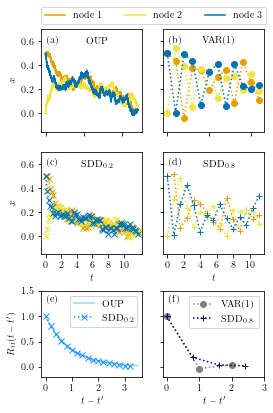

In [7]:
fsize=10
#color3 = ['#00428e','#ffea00','#afafaf']
#color3 = ['#022957','#ff8000','#6e6e6e']
color3 = ['#e69f00', '#f0e442', #'#57b4e9', '#d55e00', 
          '#0072b2']
color2 = ['tab:blue','tab:red']
color22 = [['#90e0ef','dodgerblue'],['grey', '#03045e']]
models = ['OUP', r'SDD$_{0.2}$', r'SDD$_{0.8}$', 'VAR(1)']
fig = plt.figure(figsize=(4,6.4))

for i in range(len(dts)):
    ax = plt.subplot(3,2,[1,3,4,2][i])

    for j in range(n):
        xvals = np.arange(0,T+dts[i],dts[i])[:len(X[i][j])]
        plt.plot(xvals, X[i][j], ['-','x:','+:','o:'][i], color=color3[j], label='node '+str(j+1))
    plt.ylim([-0.15,0.7])
    
    if i in [1,2]:
        ax.set_xticks(range(0,11,2))
        plt.xlabel(r'$t$', size=fsize)
    else:
        ax.set_xticklabels([])
    if i in [0,1]:
        plt.ylabel(r'$x$', size=fsize)
    else:
        ax.set_yticklabels([])
        
    ax.set_title(models[i], 
                 size=fsize, x=0.55, y=0.86, pad=0)
    if i==0:
        plt.legend(ncol=3, bbox_to_anchor=(0., 1.05, 2.22, .102), loc='lower left',
            borderaxespad=0., mode='expand')
        
    i0 = [1,3,4,2][i]-1
    ax.text(0.055,#0.84, 
            0.865, '('+['a','b','c','d'][i0]+')', transform=ax.transAxes, size=fsize)

if True:
    ax = plt.subplot(3,2,5)
    pos = ax.get_position()
    x0, x1, y0, y1 = pos.x0, pos.x1, pos.y0, pos.y1
    ax.axis('off')
    ax = fig.add_axes(Bbox([[x0,y0],[x1,y1*0.9]]))
    ax.set_ylim([-0.2,1.5])
    for i_,i in enumerate([0,1]):
        xvals = np.arange(0,3.5,dts[i])[:len(atcs[i])]
        plt.plot(xvals, atcs[i]/atcs[i][0], ['-','x:','+:','o:'][i], 
                 color=color22[0][i_], #color=color2[i_], 
                 label=models[i])
    ax.text(0.055,#0.84, 
            0.865, '(e)', transform=ax.transAxes, size=fsize)    
    plt.legend(loc=1)
    ax.set_xticks([0,1,2,3])
    ax.set_xlabel(r"$t-t'$")
    ax.set_ylabel(r"$R_{ii}(t-t')$")

    ax = plt.subplot(3,2,6)
    pos = ax.get_position()
    x0, x1, y0, y1 = pos.x0, pos.x1, pos.y0, pos.y1
    ax.axis('off')
    ax = fig.add_axes(Bbox([[x0,y0],[x1,y1*0.9]]))
    ax.set_ylim([-0.2,1.5])
    for i_,i in enumerate([3,2]):
        xvals = np.arange(0,3.5,dts[i])[:len(atcs[i])]
        plt.plot(xvals, atcs[i]/atcs[i][0], ['-','x:','+:','o:'][i], 
                 color=color22[1][i_], #color=color2[i_], 
                 label=models[i])
    ax.text(0.055,#0.84, 
            0.865, '(f)', transform=ax.transAxes, size=fsize) 
    plt.legend(loc=1)
    ax.set_xticks([0,1,2,3])
    ax.set_xlabel(r"$t-t'$")
    ax.set_yticklabels([])
    
#plt.subplots_adjust(bottom=0.25)
plt.savefig('../figures/timeseries2.pdf')

#### Make a horizontally oriented figure
(This figure does not appear in the paper)

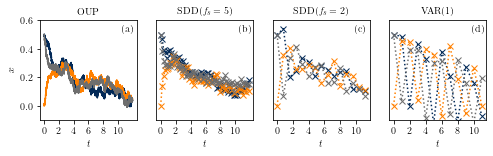

In [8]:
fsize=10
color3 = ['#00428e','#ffea00','#afafaf']
color3 = ['#022957','#ff8000','#6e6e6e']
fig = plt.figure(figsize=(8,2.2))

for i in range(len(dts)):
    ax = plt.subplot(1,len(dts),i+1)

    for j in range(n):
        xvals = np.arange(0,T+dts[i],dts[i])[:len(X[i][j])]
        if i==0:
            plt.plot(xvals, X[i][j], color=color3[j])
        else:
            plt.plot(xvals, X[i][j], 'x:', color=color3[j])
    plt.ylim([-0.1,0.6])
    plt.xlabel(r'$t$', size=fsize)
    ax.set_xticks(range(0,11,2))
    if i == 0:
        plt.ylabel(r'$x$', size=fsize)
    else:
        ax.set_yticks([])
    plt.title(['OUP', 'SDD($f_s=5$)', 'SDD($f_s=2$)', 'VAR(1)'][i], size=fsize)
    ax.text(0.84, 0.88, '('+['a','b','c','d'][i]+')', transform=ax.transAxes, size=fsize)
plt.subplots_adjust(bottom=0.25)
plt.savefig('../figures/timeseries.pdf')

if False:
    fig = plt.figure(figsize=(8,2.2))

    for i in range(len(dts)):
        ax = plt.subplot(1,len(dts),i+1)
        for j in range(n):
            if i==len(dts)-1:
                plt.plot(np.arange(0,T,1), X[i][j], 'x:', color=color3[j])
            else:
                skip = int(1/dts[i])
                plt.plot(np.arange(0,T,1), X[i][j, ::skip], 'x:', color=color3[j])
        plt.ylim([-0.1,0.6])
        plt.xlabel(r'$t$', size=fsize)

        ax.set_xticks(range(0,11,2))
        if i in [0]:
            plt.ylabel(r'$x$', size=fsize)
        else:
            ax.set_yticklabels([])

        plt.title(['OUP', 'SDD($f_s=5$)', 'SDD($f_s=2$)', 'VAR(1)'][i], size=fsize)
        ax.text(0.84, 0.88, '('+['a','b','c','d'][i]+')', transform=ax.transAxes, size=fsize)
    plt.subplots_adjust(bottom=0.25)
    plt.savefig('../figures/sampled_timeseries.pdf')